In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Execute this to save new versions of the notebook
jovian.commit(project="stock-forecasting-using-fbprophet")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/nikhilpatil3586/stock-forecasting-using-fbprophet


'https://jovian.ai/nikhilpatil3586/stock-forecasting-using-fbprophet'

# **Stock Forecasting using fbprophet**

## **fbProphet**

**Prophet** is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.

According to [Facebook Prophet website:](https://facebook.github.io/prophet/)

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well".

Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t) = g(t) + s(t) + h(t) + e(t)

Here,
**g(t)** is a trend function which models the non-periodic changes. It can be either a linear function or a logistic function.

**s(t)** represents a periodic changes i.e weekly, monthly, yearly. An yearly seasonal component is modeled using Fourier series and weekly seasonal component using dummy variables.

**h(t)** is a function that represents the effect of holidays which occur on irregular schedules.(n≥1 days)

The term **e(t)** represents error changes that are not accommodated by the model.

The research paper for prophet can be found [here](https://peerj.com/preprints/3190.pdf#section.1).

In [6]:
!pip install pystan --quiet

In [7]:
!pip install prophet --upgrade --quiet

     |████████████████████████████████| 65 kB 1.9 MB/s 
     |████████████████████████████████| 49 kB 3.4 MB/s 
     |████████████████████████████████| 179 kB 11.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


### **Yahoo Finance**

YFinance was created to help users to download data using python and it has some great features also which makes it favourable to use for stock data analysis. YFinance not only downloads the Stock Price data it also allows us to download all the financial data of a Company since its listing in the stock market. It’s easy to use and is blazingly fast. This library is pretty famous for Financial Data Analysis.

We will explore YFinance and we can do forecasting. We try to forecast the share price of Amazon Stock (2021) using the share price data from (2011-2020). YFinance is highly recommended for Financial Reporting as it provides you with each and every detail you require about the company and its stock. 

For using YFinance we first need to install it, we can install it by pip install finance. We will start by importing the required library i.e. yfinance.



In [8]:
!pip install yfinance --upgrade --quiet

     |████████████████████████████████| 6.3 MB 7.8 MB/s 


In [9]:
from prophet import Prophet
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px

# Load the data
We’ll be using AMAZON data from (2011–2020) and predict the values for (2021).

In [10]:
data = yf.download('AMZN','2011-01-01','2021-07-31') 

[*********************100%***********************]  1 of 1 completed


In [11]:
# Let us print the top five rows of the data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700


In [12]:
# Also print the last 5 observation of the data
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-26,3673.169922,3712.080078,3647.250000,3699.820068,3699.820068,2896300
2021-07-27,3698.500000,3698.500000,3586.149902,3626.389893,3626.389893,4121700
2021-07-28,3633.780029,3658.419922,3601.000000,3630.320068,3630.320068,2995000
2021-07-29,3627.750000,3637.949951,3580.010010,3599.919922,3599.919922,5356600
2021-07-30,3347.949951,3368.000000,3306.979980,3353.945068,3353.945068,7245741


In [13]:
# Now we will reset the index of the data because we want 'Date' as a column for predicting price
data= data.reset_index()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
1,2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2,2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
3,2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
4,2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700


In [14]:
# Let us check shape of the data
print('The dataset have' , data.shape[0], 'rows.')
print('The dataset have', data.shape[1], 'columns.')

The dataset have 2662 rows.
The dataset have 7 columns.


In [15]:
# Now we will check any null values present in the dataset
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

The dataset has no missing values

Since we need only two columns date and close price, so, we subset the original dataset to get these columns.

In [16]:
df = data[['Date', 'Close']]

Since the data is required in a prophet in the form of two columns named ds (for date column) and y (for data column).


In [17]:
# Renaming the column names
df.columns = ['ds', 'y']
# Let us print the first five rows 
df.head()

,ds,y
0,2011-01-03,184.220001
1,2011-01-04,185.009995
2,2011-01-05,187.419998
3,2011-01-06,185.860001
4,2011-01-07,185.490005


Now, lets visualize the dataset.

In [18]:
fig = px.line(df, x='ds', y='y', title='Closing Price of AMAZON Stock')

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
                        dict(count = 1, label = '1yr', step = 'year', stepmode = 'backward'),
                        dict(count = 2, label = '3yr', step = 'year', stepmode = 'backward'),
                        dict(count = 3, label = '5yr', step = 'year', stepmode = 'backward'),
                        dict(step = 'all')
        ])
    )
)
fig.show()

In [19]:
# Let us split dataset into two parts train and test
split_date = "2020-12-31"
train_df = df.loc[df.ds <= split_date].copy()
test_df = df.loc[df.ds > split_date].copy()

In [20]:
train_df.tail()

,ds,y
2512,2020-12-24,3172.689941
2513,2020-12-28,3283.959961
2514,2020-12-29,3322.000000
2515,2020-12-30,3285.850098
2516,2020-12-31,3256.929932


In [21]:
test_df.tail()

,ds,y
2657,2021-07-26,3699.820068
2658,2021-07-27,3626.389893
2659,2021-07-28,3630.320068
2660,2021-07-29,3599.919922
2661,2021-07-30,3353.945068


Now, we instantiate the Facebook prophet API, this prophet API works similar to scikit-learn. It uses the fit function to fit the dataset into the model and predict function to forecast future values.


In [22]:
# Now we Instantiate prophet 
model = Prophet()

In [23]:
# fit the training data 
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now, we use predict function to forecast the share price for next 1 year.


In [25]:
forecast = model.predict(test_df)

In [26]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
140,2021-07-26,3532.326957,3393.575831,3825.445464,3425.597543,3656.847078,65.793391,65.793391,65.793391,-0.967243,-0.967243,-0.967243,66.760634,66.760634,66.760634,0.0,0.0,0.0,3598.120348
141,2021-07-27,3534.561027,3371.036078,3816.989256,3428.195837,3659.951890,65.133909,65.133909,65.133909,0.504481,0.504481,0.504481,64.629427,64.629427,64.629427,0.0,0.0,0.0,3599.694935
142,2021-07-28,3536.795097,3398.336267,3820.464211,3429.118887,3663.056701,65.248958,65.248958,65.248958,2.868300,2.868300,2.868300,62.380658,62.380658,62.380658,0.0,0.0,0.0,3602.044055
143,2021-07-29,3539.029167,3393.854693,3823.560091,3430.041938,3666.318472,61.850180,61.850180,61.850180,1.787785,1.787785,1.787785,60.062395,60.062395,60.062395,0.0,0.0,0.0,3600.879346
144,2021-07-30,3541.263237,3383.508000,3810.271815,3430.964988,3670.235207,55.778422,55.778422,55.778422,-1.945185,-1.945185,-1.945185,57.723607,57.723607,57.723607,0.0,0.0,0.0,3597.041659


As we can see forecasted dataset contains the date column, predict share price (y_hat), lower and upper estimates of it, trend components, seasonal components (weekly and yearly).


In [27]:
# Now, we will visualize the predictions
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

When trends need to be seen from weekly or monthly basis, the prophet has another function as components.


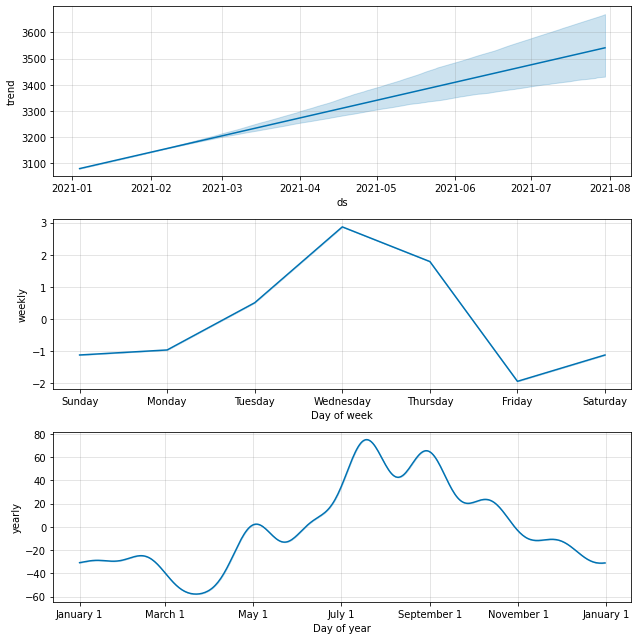

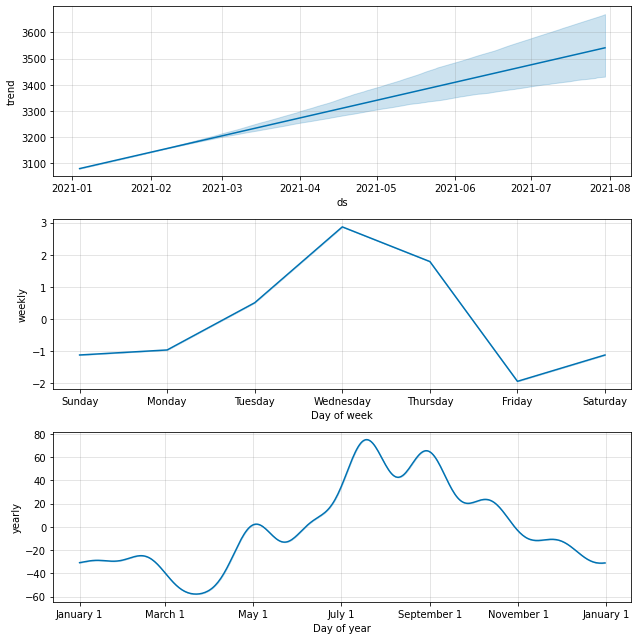

In [28]:
model.plot_components(forecast)

Now, we calculate the mean square error and mean absolute error for the forecasted data.

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
print("Mean Squared Error (MSE):", mean_squared_error(y_true = test_df["y"], y_pred = forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = test_df["y"], y_pred = forecast['yhat']))

Mean Squared Error (MSE): 15527.189316279197
Mean Absolute Error (MAE): 107.33702635266557


Now, we calculate the mean absolute percentage error of our forecast, because it gives a better idea about how accurate our prediction is


In [31]:
def mean_abs_perc_err(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
print("Mean Absolute % Error (MAPE): ", mean_abs_perc_err(y_true = np.asarray(test_df["y"]), y_pred = np.asarray(forecast['yhat'])))


Mean Absolute % Error (MAPE):  3.2822526369402034


References:

1.https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

2.https://peerj.com/preprints/3190/


In [22]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/nikhilpatil3586/stock-forecasting-using-fbprophet


'https://jovian.ai/nikhilpatil3586/stock-forecasting-using-fbprophet'